In [2]:
%config IPCompleter.greedy=True

import tensorflow as tf;
import matplotlib.pyplot as plt
from keras.datasets import mnist, cifar10
from keras.layers import Input, MaxPool2D
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np


Using TensorFlow backend.


In [3]:
number_train = 10000
number_test  = 1000

In [4]:
IMG_SIZE = 32
input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

W0901 00:17:19.077029 140230655723328 deprecation_wrapper.py:119] From /home/sysadm/Workspace/jupyter/Deep-SAD-PyTorch/env3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 00:17:19.097244 140230655723328 deprecation_wrapper.py:119] From /home/sysadm/Workspace/jupyter/Deep-SAD-PyTorch/env3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



# LISS EDDY Current

X Train: (7756, 32, 32, 3)
X Test: (1940, 32, 32, 3)


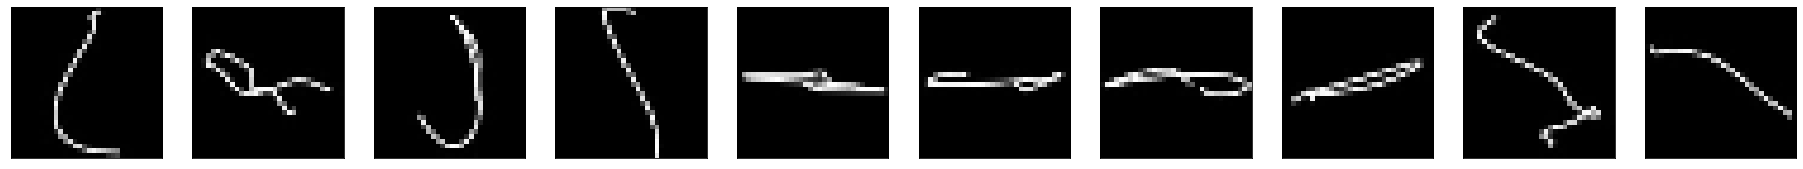

In [5]:
IMG_PATH = 'data_80_80/'
images = [f for f in listdir(IMG_PATH) if isfile(join(IMG_PATH, f))]

X = []
y = []

# loop trough all images
for f in images:
    data = (cv2.imread(IMG_PATH + f, 0))
    data = cv2.cvtColor(cv2.resize(data, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_GRAY2BGR)
    X.append(data)
X = np.array(X)
y = np.ones(len(X))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

x_train = x_train/255.
x_test = x_test/255.

#Plot data liss
plt.figure(figsize=(IMG_SIZE, IMG_SIZE))
num_image = 10
for i in range(num_image):
    ax = plt.subplot(1, num_image, i+1)
    plt.imshow(x_train[i].reshape(IMG_SIZE, IMG_SIZE,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print ( 'X Train: ' + str(x_train.shape))
print ( 'X Test: ' + str(x_test.shape))

# CIFAR10 Data set

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:number_train]/255.
x_test = x_test[:number_test]/255.
print ( 'X Train: ' + str(x_train.shape))
print ( 'Y Train: ' + str(y_train.shape))

X Train: (10000, 32, 32, 3)
Y Train: (50000, 1)


#  Mnist Data set

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
    
x_train = x_train[:number_train]
x_test = x_test[:number_test]

# converting to RGB
x_train = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_train]
x_train = np.concatenate([arr[np.newaxis] for arr in x_train]).astype('float32')

x_test = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_test]
x_test = np.concatenate([arr[np.newaxis] for arr in x_test]).astype('float32')

x_train = x_train/255.
x_test = x_test/255.

print(x_train.shape)
print(x_test.shape)

(10000, 32, 32, 3)
(1000, 32, 32, 3)


# Best VGG16 Decoder => model and weights: jimmy_vgg16_autoencoder.m1

In [7]:
# Default using VGG16 with weight from imagenet
encoder = VGG16(input_tensor=input, weights='imagenet', include_top=False) 
#encoder = VGG16(input_tensor=input, weights=None, include_top=False)
encoder.summary()
x = encoder.output
x = UpSampling2D(size=(2,2),                                       name=  'de_block5_pool')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block5_conv3')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block5_conv2')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block5_conv1')(x)
x = UpSampling2D(size=(2,2),                                       name = 'de_block4_pool')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block4_conv3')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block4_conv2')(x)
x = Conv2D(512,(3,3), activation='relu', padding='same',           name = 'de_block4_conv1')(x)
x = UpSampling2D(size=(2,2),                                       name = 'de_block3_pool')(x)
x = Conv2D(256,(3,3), activation='relu', padding='same',           name = 'de_block3_conv3')(x)
x = Conv2D(256,(3,3), activation='relu', padding='same',           name = 'de_block3_conv2')(x)
x = Conv2D(256,(3,3), activation='relu', padding='same',           name = 'de_block3_conv1')(x)
x = UpSampling2D(size=(2,2),                                       name = 'de_block2_pool')(x)
x = Conv2D(128,(3,3), activation='relu', padding='same',           name = 'de_block2_conv2')(x)
x = Conv2D(128,(3,3), activation='relu', padding='same',           name = 'de_block2_conv1')(x)
x = UpSampling2D(size=(2,2),                                       name = 'de_block1_pool')(x)
x = Conv2D(64,(3,3), activation='relu', padding='same',            name = 'de_block1_conv2')(x)
x = Conv2D(64,(3,3), activation='relu', padding='same',            name = 'de_block1_conv1')(x)

decoded = Conv2D(3,(3,3), padding='same',                          name = 'de_block0_conv1')(x)

autoencoder = Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()


W0801 15:46:23.073709 140338515666752 deprecation_wrapper.py:119] From /home/sysadm/Workspace/jupyter/Deep-SAD-PyTorch/env3.7/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

# Tesing AutoEncoder

In [ ]:
# encoding architecture
encoded= Conv2D(64, (3, 3), activation='relu', padding='same',  name = "E1")(input)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same', name = "E2")(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same', name = "E3")(encoded)
encoded = MaxPool2D( (2, 2), padding='same',                    name = "E4")(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "E5")(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "E6")(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "E7")(encoded)
encoded = MaxPool2D( (2, 2), padding='same',                    name = "E8")(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "E9")(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "E10")(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "E11")(encoded)
encoded = MaxPool2D( (2, 2), padding='same',                    name = "E12")(encoded)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same',name = "E13")(encoded)
encoded = MaxPool2D( (2, 2), padding='same',                    name = "E14")(encoded)
encoded = Conv2D(512, (3, 3), activation='relu', padding='same',name = "E15")(encoded)
encoded = MaxPool2D( (2, 2), padding='same',                    name = "E16")(encoded)
latent_view = encoded

# decoding architecture
decoded = latent_view
decoded = Conv2D(512, (3, 3), activation='relu', padding='same',name = "D16")(decoded)
decoded = UpSampling2D((2, 2),                                  name = "D15")(decoded)
decoded = Conv2D(512, (3, 3), activation='relu', padding='same',name = "D14")(decoded)
decoded = UpSampling2D((2, 2),                                  name = "D13")(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "D12")(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "D11")(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same', name = "D10")(decoded)
decoded = UpSampling2D((2, 2),                                  name = "D9")(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "D8")(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "D7")(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same', name = "D6")(decoded)
decoded = UpSampling2D((2, 2),                                  name = "D5")(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same', name = "D4")(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same', name = "D3")(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same', name = "D2")(decoded)
decoded = UpSampling2D((2, 2),                                  name = "D1")(decoded)
output   = Conv2D(3, (3, 3), padding='same',                    name = "D0")(decoded)


# compile the model
autoencoder = Model(input, output)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

In [10]:

epochs = 250
batch_size = 80

history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]).history

Train on 7756 samples, validate on 1940 samples
Epoch 1/250
7756/7756 [==============================] - 5s 647us/step - loss: 0.0101 - acc: 0.4305 - val_loss: 0.0164 - val_acc: 0.1492
Epoch 2/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0100 - acc: 0.4443 - val_loss: 0.0161 - val_acc: 0.7300
Epoch 3/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0100 - acc: 0.4311 - val_loss: 0.0162 - val_acc: 0.1276
Epoch 4/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0100 - acc: 0.3839 - val_loss: 0.0165 - val_acc: 0.1215
Epoch 5/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0102 - acc: 0.4867 - val_loss: 0.0165 - val_acc: 0.1533
Epoch 6/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0102 - acc: 0.4163 - val_loss: 0.0172 - val_acc: 0.7358
Epoch 7/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0106 - acc: 0.4653 - val_loss: 0.0163 - val_acc: 

7756/7756 [==============================] - 5s 645us/step - loss: 0.0071 - acc: 0.3941 - val_loss: 0.0169 - val_acc: 0.1705
Epoch 61/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0071 - acc: 0.4603 - val_loss: 0.0169 - val_acc: 0.7780
Epoch 62/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0075 - acc: 0.3517 - val_loss: 0.0172 - val_acc: 0.1430
Epoch 63/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0076 - acc: 0.2094 - val_loss: 0.0171 - val_acc: 0.7695
Epoch 64/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0079 - acc: 0.4318 - val_loss: 0.0170 - val_acc: 0.1384
Epoch 65/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0075 - acc: 0.2907 - val_loss: 0.0171 - val_acc: 0.1417
Epoch 66/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0074 - acc: 0.2306 - val_loss: 0.0171 - val_acc: 0.1760
Epoch 67/250
7756/7756 [=======================

7756/7756 [==============================] - 5s 644us/step - loss: 0.0044 - acc: 0.3619 - val_loss: 0.0178 - val_acc: 0.1099
Epoch 179/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0041 - acc: 0.3731 - val_loss: 0.0177 - val_acc: 0.0698
Epoch 180/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0043 - acc: 0.3361 - val_loss: 0.0175 - val_acc: 0.1697
Epoch 181/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0045 - acc: 0.3742 - val_loss: 0.0179 - val_acc: 0.8251
Epoch 182/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0042 - acc: 0.3581 - val_loss: 0.0175 - val_acc: 0.9320
Epoch 183/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0039 - acc: 0.3114 - val_loss: 0.0179 - val_acc: 0.8784
Epoch 184/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0038 - acc: 0.3812 - val_loss: 0.0177 - val_acc: 0.0795
Epoch 185/250
7756/7756 [================

7756/7756 [==============================] - 5s 645us/step - loss: 0.0040 - acc: 0.3619 - val_loss: 0.0180 - val_acc: 0.8237
Epoch 238/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0038 - acc: 0.4049 - val_loss: 0.0180 - val_acc: 0.0645
Epoch 239/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0036 - acc: 0.3646 - val_loss: 0.0182 - val_acc: 0.8550
Epoch 240/250
7756/7756 [==============================] - 5s 645us/step - loss: 0.0030 - acc: 0.4242 - val_loss: 0.0179 - val_acc: 0.8494
Epoch 241/250
7756/7756 [==============================] - 5s 644us/step - loss: 0.0028 - acc: 0.3319 - val_loss: 0.0180 - val_acc: 0.1349
Epoch 242/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0027 - acc: 0.4091 - val_loss: 0.0179 - val_acc: 0.9345
Epoch 243/250
7756/7756 [==============================] - 5s 646us/step - loss: 0.0026 - acc: 0.3657 - val_loss: 0.0179 - val_acc: 0.0629
Epoch 244/250
7756/7756 [================

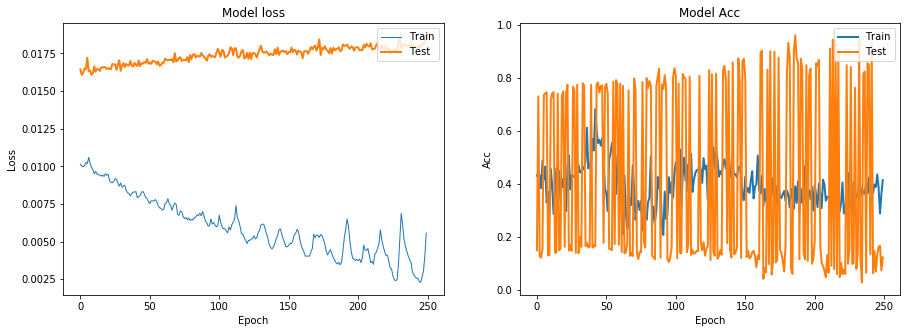

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(history['loss'], linewidth=1, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.show()